In [10]:
import os
import glob
import shutil
from PIL import Image as PILImage
import numpy as np
import skimage as sk
from skimage.filters import gaussian
from scipy.ndimage import zoom as scizoom
import cv2
from io import BytesIO
import ctypes
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt


In [11]:

def disk(radius, alias_blur=0.1, dtype=np.float32):
    if radius <= 8:
        L = np.arange(-8, 8 + 1)
        ksize = (3, 3)
    else:
        L = np.arange(-radius, radius + 1)
        ksize = (5, 5)
    X, Y = np.meshgrid(L, L)
    aliased_disk = np.array((X ** 2 + Y ** 2) <= radius ** 2, dtype=dtype)
    aliased_disk /= np.sum(aliased_disk)

    # supersample disk to antialias
    return cv2.GaussianBlur(aliased_disk, ksize=ksize, sigmaX=alias_blur)


# modification of https://github.com/FLHerne/mapgen/blob/master/diamondsquare.py
def plasma_fractal(mapsize=256, wibbledecay=3):
    """
    Generate a heightmap using diamond-square algorithm.
    Return square 2d array, side length 'mapsize', of floats in range 0-255.
    'mapsize' must be a power of two.
    """
    assert (mapsize & (mapsize - 1) == 0)
    maparray = np.empty((mapsize, mapsize), dtype=np.float64)
    maparray[0, 0] = 0
    stepsize = mapsize
    wibble = 100

    def wibbledmean(array):
        return array / 4 + wibble * np.random.uniform(-wibble, wibble, array.shape)

    def fillsquares():
        """For each square of points stepsize apart,
           calculate middle value as mean of points + wibble"""
        cornerref = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        squareaccum = cornerref + np.roll(cornerref, shift=-1, axis=0)
        squareaccum += np.roll(squareaccum, shift=-1, axis=1)
        maparray[stepsize // 2:mapsize:stepsize,
        stepsize // 2:mapsize:stepsize] = wibbledmean(squareaccum)

    def filldiamonds():
        """For each diamond of points stepsize apart,
           calculate middle value as mean of points + wibble"""
        mapsize = maparray.shape[0]
        drgrid = maparray[stepsize // 2:mapsize:stepsize, stepsize // 2:mapsize:stepsize]
        ulgrid = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        ldrsum = drgrid + np.roll(drgrid, 1, axis=0)
        lulsum = ulgrid + np.roll(ulgrid, -1, axis=1)
        ltsum = ldrsum + lulsum
        maparray[0:mapsize:stepsize, stepsize // 2:mapsize:stepsize] = wibbledmean(ltsum)
        tdrsum = drgrid + np.roll(drgrid, 1, axis=1)
        tulsum = ulgrid + np.roll(ulgrid, -1, axis=0)
        ttsum = tdrsum + tulsum
        maparray[stepsize // 2:mapsize:stepsize, 0:mapsize:stepsize] = wibbledmean(ttsum)

    while stepsize >= 2:
        fillsquares()
        filldiamonds()
        stepsize //= 2
        wibble /= wibbledecay

    maparray -= maparray.min()
    return maparray / maparray.max()


def clipped_zoom(img, zoom_factor):
    h = img.shape[0]
    # ceil crop height(= crop width)
    ch = int(np.ceil(h / float(zoom_factor)))

    top = (h - ch) // 2
    img = scizoom(img[top:top + ch, top:top + ch], (zoom_factor, zoom_factor, 1), order=1)
    # trim off any extra pixels
    trim_top = (img.shape[0] - h) // 2

    return img[trim_top:trim_top + h, trim_top:trim_top + h]


# # /////////////// End Corruption Helpers ///////////////


# # /////////////// Corruptions ///////////////

def gaussian_noise(x, severity=1):
    c = [.08, .12, 0.18, 0.26, 0.38][severity - 1]

    x = np.array(x) / 255.
    return np.clip(x + np.random.normal(size=x.shape, scale=c), 0, 1) * 255


def shot_noise(x, severity=1):
    c = [60, 25, 12, 5, 3][severity - 1]

    x = np.array(x) / 255.
    return np.clip(np.random.poisson(x * c) / float(c), 0, 1) * 255


def impulse_noise(x, severity=1):
    c = [.03, .06, .09, 0.17, 0.27][severity - 1]

    x = sk.util.random_noise(np.array(x) / 255., mode='s&p', amount=c)
    return np.clip(x, 0, 1) * 255


def speckle_noise(x, severity=1):
    c = [.15, .2, 0.35, 0.45, 0.6][severity - 1]

    x = np.array(x) / 255.
    return np.clip(x + x * np.random.normal(size=x.shape, scale=c), 0, 1) * 255


def gaussian_blur(x, severity=1):
    c = [1, 2, 3, 4, 6][severity - 1]

    x = gaussian(np.array(x) / 255., sigma=c)
    return np.clip(x, 0, 1) * 255


def glass_blur(x, severity=1):
    # sigma, max_delta, iterations
    c = [(0.7, 1, 2), (0.9, 2, 1), (1, 2, 3), (1.1, 3, 2), (1.5, 4, 2)][severity - 1]

    x = np.uint8(gaussian(np.array(x) / 255., sigma=c[0]) * 255)

    # locally shuffle pixels
    for i in range(c[2]):
        for h in range(224 - c[1], c[1], -1):
            for w in range(224 - c[1], c[1], -1):
                dx, dy = np.random.randint(-c[1], c[1], size=(2,))
                h_prime, w_prime = h + dy, w + dx
                # swap
                x[h, w], x[h_prime, w_prime] = x[h_prime, w_prime], x[h, w]

    return np.clip(gaussian(x / 255., sigma=c[0]), 0, 1) * 255


def defocus_blur(x, severity=1):
    c = [(3, 0.1), (4, 0.5), (6, 0.5), (8, 0.5), (10, 0.5)][severity - 1]

    x = np.array(x) / 255.
    kernel = disk(radius=c[0], alias_blur=c[1])

    channels = []
    for d in range(3):
        channels.append(cv2.filter2D(x[:, :, d], -1, kernel))
    channels = np.array(channels).transpose((1, 2, 0))  # 3x224x224 -> 224x224x3

    return np.clip(channels, 0, 1) * 255

def zoom_blur(x, severity=1):
    c = [np.arange(1, 1.11, 0.01),
         np.arange(1, 1.16, 0.01),
         np.arange(1, 1.21, 0.02),
         np.arange(1, 1.26, 0.02),
         np.arange(1, 1.31, 0.03)][severity - 1]

    x = (np.array(x) / 255.).astype(np.float32)
    out = np.zeros_like(x)
    for zoom_factor in c:
        out += clipped_zoom(x, zoom_factor)

    x = (x + out) / (len(c) + 1)
    return np.clip(x, 0, 1) * 255

def fog(x, severity=1):
    c = [(1.5, 2), (2., 2), (2.5, 1.7), (2.5, 1.5), (3., 1.4)][severity - 1]

    x = np.array(x) / 255.
    H, W, _ = x.shape
    max_val = x.max()

    heightmap = plasma_fractal(mapsize=256, wibbledecay=c[1])  # lav 256x256
    # skaler til billedets dimensioner
    heightmap = cv2.resize(heightmap, (W, H), interpolation=cv2.INTER_LINEAR)
    heightmap = heightmap[..., np.newaxis]  # tilføj kanal

    x += c[0] * heightmap
    return np.clip(x * max_val / (max_val + c[0]), 0, 1) * 255

def spatter(x, severity=1):
    c = [(0.65, 0.3, 4, 0.69, 0.6, 0),
         (0.65, 0.3, 3, 0.68, 0.6, 0),
         (0.65, 0.3, 2, 0.68, 0.5, 0),
         (0.65, 0.3, 1, 0.65, 1.5, 1),
         (0.67, 0.4, 1, 0.65, 1.5, 1)][severity - 1]
    x = np.array(x, dtype=np.float32) / 255.

    liquid_layer = np.random.normal(size=x.shape[:2], loc=c[0], scale=c[1])

    liquid_layer = gaussian(liquid_layer, sigma=c[2])
    liquid_layer[liquid_layer < c[3]] = 0
    if c[5] == 0:
        liquid_layer = (liquid_layer * 255).astype(np.uint8)
        dist = 255 - cv2.Canny(liquid_layer, 50, 150)
        dist = cv2.distanceTransform(dist, cv2.DIST_L2, 5)
        _, dist = cv2.threshold(dist, 20, 20, cv2.THRESH_TRUNC)
        dist = cv2.blur(dist, (3, 3)).astype(np.uint8)
        dist = cv2.equalizeHist(dist)
        ker = np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]])
        dist = cv2.filter2D(dist, cv2.CV_8U, ker)
        dist = cv2.blur(dist, (3, 3)).astype(np.float32)

        m = cv2.cvtColor(liquid_layer * dist, cv2.COLOR_GRAY2BGRA)
        m /= np.max(m, axis=(0, 1))
        m *= c[4]

        # water is pale turqouise
        color = np.concatenate((175 / 255. * np.ones_like(m[..., :1]),
                                238 / 255. * np.ones_like(m[..., :1]),
                                238 / 255. * np.ones_like(m[..., :1])), axis=2)

        color = cv2.cvtColor(color, cv2.COLOR_BGR2BGRA)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2BGRA)

        return cv2.cvtColor(np.clip(x + m * color, 0, 1), cv2.COLOR_BGRA2BGR) * 255
    else:
        m = np.where(liquid_layer > c[3], 1, 0)
        m = gaussian(m.astype(np.float32), sigma=c[4])
        m[m < 0.8] = 0

        # mud brown
        color = np.concatenate((63 / 255. * np.ones_like(x[..., :1]),
                                42 / 255. * np.ones_like(x[..., :1]),
                                20 / 255. * np.ones_like(x[..., :1])), axis=2)

        color *= m[..., np.newaxis]
        x *= (1 - m[..., np.newaxis])

        return np.clip(x + color, 0, 1) * 255


def contrast(x, severity=1):
    c = [0.4, .3, .2, .1, .05][severity - 1]

    x = np.array(x) / 255.
    means = np.mean(x, axis=(0, 1), keepdims=True)
    return np.clip((x - means) * c + means, 0, 1) * 255


def brightness(x, severity=1):
    c = [.1, .2, .3, .4, .5][severity - 1]

    x = np.array(x) / 255.
    x = sk.color.rgb2hsv(x)
    x[:, :, 2] = np.clip(x[:, :, 2] + c, 0, 1)
    x = sk.color.hsv2rgb(x)

    return np.clip(x, 0, 1) * 255


def saturate(x, severity=1):
    c = [(0.3, 0), (0.1, 0), (2, 0), (5, 0.1), (20, 0.2)][severity - 1]

    x = np.array(x) / 255.
    x = sk.color.rgb2hsv(x)
    x[:, :, 1] = np.clip(x[:, :, 1] * c[0] + c[1], 0, 1)
    x = sk.color.hsv2rgb(x)

    return np.clip(x, 0, 1) * 255

def jpeg_compression(x, severity=1):
    c = [25, 18, 15, 10, 7][severity - 1]

    output = BytesIO()
    x.save(output, 'JPEG', quality=c)
    x = PILImage.open(output)

    return x

def pixelate(x, severity=1):
    c = [0.6, 0.5, 0.4, 0.3, 0.25][severity - 1]

    x = x.resize((int(224 * c), int(224 * c)), PILImage.BOX)
    x = x.resize((224, 224), PILImage.BOX)

    return x

# mod of https://gist.github.com/erniejunior/601cdf56d2b424757de5
def elastic_transform(image, severity=1):
    c = [(244 * 2, 244 * 0.7, 244 * 0.1),   # 244 should have been 224, but ultimately nothing is incorrect
         (244 * 2, 244 * 0.08, 244 * 0.2),
         (244 * 0.05, 244 * 0.01, 244 * 0.02),
         (244 * 0.07, 244 * 0.01, 244 * 0.02),
         (244 * 0.12, 244 * 0.01, 244 * 0.02)][severity - 1]

    image = np.array(image, dtype=np.float32) / 255.
    shape = image.shape
    shape_size = shape[:2]

    # random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size,
                       [center_square[0] + square_size, center_square[1] - square_size],
                       center_square - square_size])
    pts2 = pts1 + np.random.uniform(-c[2], c[2], size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = (gaussian(np.random.uniform(-1, 1, size=shape[:2]),
                   c[1], mode='reflect', truncate=3) * c[0]).astype(np.float32)
    dy = (gaussian(np.random.uniform(-1, 1, size=shape[:2]),
                   c[1], mode='reflect', truncate=3) * c[0]).astype(np.float32)
    dx, dy = dx[..., np.newaxis], dy[..., np.newaxis]

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1)), np.reshape(z, (-1, 1))
    return np.clip(map_coordinates(image, indices, order=1, mode='reflect').reshape(shape), 0, 1) * 255

def masking(image, severity=1):

    if isinstance(image, PILImage.Image):
        image = np.array(image)

    height, width, _ = image.shape

    for _ in range(severity):

        x1 = np.random.randint(0, width // 2)
        y1 = np.random.randint(0, height // 2)

        w = np.random.randint(width // 15, width // 4)
        h = np.random.randint(height // 15, height // 4)

        image[y1:y1+h, x1:x1+w] = 0

    return PILImage.fromarray(image)

# /////////////// End Corruptions ///////////////

In [12]:
def make_dataset(src_root, dst_root, corruption_func, severity=1, noisy_percentage=1):
    if os.path.exists(dst_root) and any(os.scandir(os.path.join(dst_root, "train"))):
        print(f"Dataset '{dst_root}' already exists, skipping...")
        return

    for split in ["train", "test"]:
        src_dir = os.path.join(src_root, split)
        dst_dir = os.path.join(dst_root, split)
        os.makedirs(dst_dir, exist_ok=True)

        img_paths = sorted(glob.glob(os.path.join(src_dir, "*.png")))
        num_imgs = len(img_paths)

        num_noisy_imgs = int(num_imgs * noisy_percentage)
        noisy_imgs_indices = np.random.choice(num_imgs, num_noisy_imgs, replace=False)
        noisy_imgs = [img_paths[i] for i in noisy_imgs_indices]

        for img_path in img_paths:
            img = PILImage.open(img_path).convert("RGB")

            if img_path in noisy_imgs:
                corrupted = corruption_func(img, severity=severity)
                if isinstance(corrupted, np.ndarray):
                    corrupted = PILImage.fromarray(np.uint8(np.clip(corrupted, 0, 255)))
                img_to_save = corrupted
            else:
                img_to_save = img

            img_to_save.save(os.path.join(dst_dir, os.path.basename(img_path)))

            label_path = os.path.splitext(img_path)[0] + ".npy"
            if os.path.exists(label_path):
                shutil.copy(label_path, os.path.join(dst_dir, os.path.basename(label_path)))

    print(f"Created dataset '{dst_root}' with {int(noisy_percentage*100)}% noisy data and {int((1-noisy_percentage)*100)}% clean data.")



corruptions = [
    gaussian_noise,
    shot_noise,
    impulse_noise,
    speckle_noise,
    gaussian_blur,
    glass_blur,
    defocus_blur,
    zoom_blur,
    fog,
    spatter,
    contrast,
    brightness,
    saturate,
    jpeg_compression,
    pixelate,
    elastic_transform,
    masking
]

# Severity levels, kun 1, 3 og 5
severity_levels = [1, 3, 5]

base = "ddpm-segmentation/datasets/ucloud horse_21 exp"
src_root = os.path.join(base, "../horse_21/real")

for corruption in corruptions:
    for severity in severity_levels:
        dst_root = os.path.join(base, f"{corruption.__name__}_severity{severity}")
        make_dataset(src_root, dst_root, corruption_func=corruption, severity=severity)



Dataset 'ddpm-segmentation/datasets/ucloud horse_21 exp\gaussian_noise_severity1' already exists, skipping...
Dataset 'ddpm-segmentation/datasets/ucloud horse_21 exp\gaussian_noise_severity3' already exists, skipping...
Dataset 'ddpm-segmentation/datasets/ucloud horse_21 exp\gaussian_noise_severity5' already exists, skipping...
Dataset 'ddpm-segmentation/datasets/ucloud horse_21 exp\shot_noise_severity1' already exists, skipping...
Dataset 'ddpm-segmentation/datasets/ucloud horse_21 exp\shot_noise_severity3' already exists, skipping...
Dataset 'ddpm-segmentation/datasets/ucloud horse_21 exp\shot_noise_severity5' already exists, skipping...
Dataset 'ddpm-segmentation/datasets/ucloud horse_21 exp\impulse_noise_severity1' already exists, skipping...
Dataset 'ddpm-segmentation/datasets/ucloud horse_21 exp\impulse_noise_severity3' already exists, skipping...
Dataset 'ddpm-segmentation/datasets/ucloud horse_21 exp\impulse_noise_severity5' already exists, skipping...
Dataset 'ddpm-segmentatio

In [13]:
selected_corruptions = [
    gaussian_noise,
    brightness,
    masking,
    saturate,
    jpeg_compression,
    elastic_transform
]

severity_levels = [1, 3, 5]  # Kun severity 1 og 3
noisy_percentages = [0.1, 0.2, 0.3]  # 10%, 20%, 30% noisy images

base = "ddpm-segmentation/datasets/ucloud_horse_21_mixed_exp"
src_root = os.path.join(base, "../horse_21/real")

for corruption in selected_corruptions:
    for severity in severity_levels:
        for noisy_pct in noisy_percentages:
            dst_root = os.path.join(base, f"{corruption.__name__}_severity{severity}_{int(noisy_pct*100)}pct")
            make_dataset(src_root, dst_root, corruption_func=corruption, severity=severity, noisy_percentage=noisy_pct)

Dataset 'ddpm-segmentation/datasets/ucloud_horse_21_mixed_exp\gaussian_noise_severity1_10pct' already exists, skipping...
Dataset 'ddpm-segmentation/datasets/ucloud_horse_21_mixed_exp\gaussian_noise_severity1_20pct' already exists, skipping...
Dataset 'ddpm-segmentation/datasets/ucloud_horse_21_mixed_exp\gaussian_noise_severity1_30pct' already exists, skipping...
Dataset 'ddpm-segmentation/datasets/ucloud_horse_21_mixed_exp\gaussian_noise_severity3_10pct' already exists, skipping...
Dataset 'ddpm-segmentation/datasets/ucloud_horse_21_mixed_exp\gaussian_noise_severity3_20pct' already exists, skipping...
Dataset 'ddpm-segmentation/datasets/ucloud_horse_21_mixed_exp\gaussian_noise_severity3_30pct' already exists, skipping...
Dataset 'ddpm-segmentation/datasets/ucloud_horse_21_mixed_exp\gaussian_noise_severity5_10pct' already exists, skipping...
Dataset 'ddpm-segmentation/datasets/ucloud_horse_21_mixed_exp\gaussian_noise_severity5_20pct' already exists, skipping...
Dataset 'ddpm-segmentati

In [14]:
def make_mixed_dataset(src_root, dst_root, corruption_funcs, severity=1, per_corruption_pct=0.1):
    if os.path.exists(dst_root) and any(os.scandir(os.path.join(dst_root, "train"))):
        print(f"Dataset '{dst_root}' already exists, skipping...")
        return

    for split in ["train", "test"]:
        src_dir = os.path.join(src_root, split)
        dst_dir = os.path.join(dst_root, split)
        os.makedirs(dst_dir, exist_ok=True)

        img_paths = sorted(glob.glob(os.path.join(src_dir, "*.png")))
        num_imgs = len(img_paths)
        img_paths_copy = img_paths.copy()

        num_per_corruption = int(num_imgs * per_corruption_pct)
        total_corrupted = num_per_corruption * len(corruption_funcs)

        np.random.shuffle(img_paths_copy)

        corruption_map = {}
        start = 0
        for func in corruption_funcs:
            end = start + num_per_corruption
            corruption_map[func] = img_paths_copy[start:end]
            start = end

        for img_path in img_paths:
            img = PILImage.open(img_path).convert("RGB")
            base_name = os.path.basename(img_path)

            func_to_apply = None
            for func, paths in corruption_map.items():
                if img_path in paths:
                    func_to_apply = func
                    break

            if func_to_apply:
                corrupted = func_to_apply(img, severity=severity)
                if isinstance(corrupted, np.ndarray):
                    corrupted = PILImage.fromarray(np.uint8(np.clip(corrupted, 0, 255)))
                img_to_save = corrupted

                # 🟩 Tilføj prefix med corruption type i filnavnet
                corruption_prefix = func_to_apply.__name__
                save_name = f"{corruption_prefix}_{base_name}"
            else:
                img_to_save = img  # clean
                save_name = base_name  # gem som normalt

            # Gem billede
            img_to_save.save(os.path.join(dst_dir, save_name))

            # Kopiér label med samme navn (men .npy)
            label_path = os.path.splitext(img_path)[0] + ".npy"
            if os.path.exists(label_path):
                dst_label_name = os.path.splitext(save_name)[0] + ".npy"
                shutil.copy(label_path, os.path.join(dst_dir, dst_label_name))

    clean_pct = 1 - per_corruption_pct * len(corruption_funcs)
    print(f"Created '{dst_root}' | {int(per_corruption_pct*100)}% of each corruption × {len(corruption_funcs)} = {int((1-clean_pct)*100)}% total noisy | {int(clean_pct*100)}% clean")


In [15]:
base = "ddpm-segmentation/datasets/ucloud_horse_21_mixed_exp"
src_root = os.path.join(base, "../horse_21/real")

severity_levels = [1, 3, 5]

for severity in severity_levels:
    dst_root = os.path.join(base, f"mixed_severity{severity}_10pct_each")
    make_mixed_dataset(src_root, dst_root, selected_corruptions, severity=severity, per_corruption_pct=0.1)


Dataset 'ddpm-segmentation/datasets/ucloud_horse_21_mixed_exp\mixed_severity1_10pct_each' already exists, skipping...
Dataset 'ddpm-segmentation/datasets/ucloud_horse_21_mixed_exp\mixed_severity3_10pct_each' already exists, skipping...
Dataset 'ddpm-segmentation/datasets/ucloud_horse_21_mixed_exp\mixed_severity5_10pct_each' already exists, skipping...


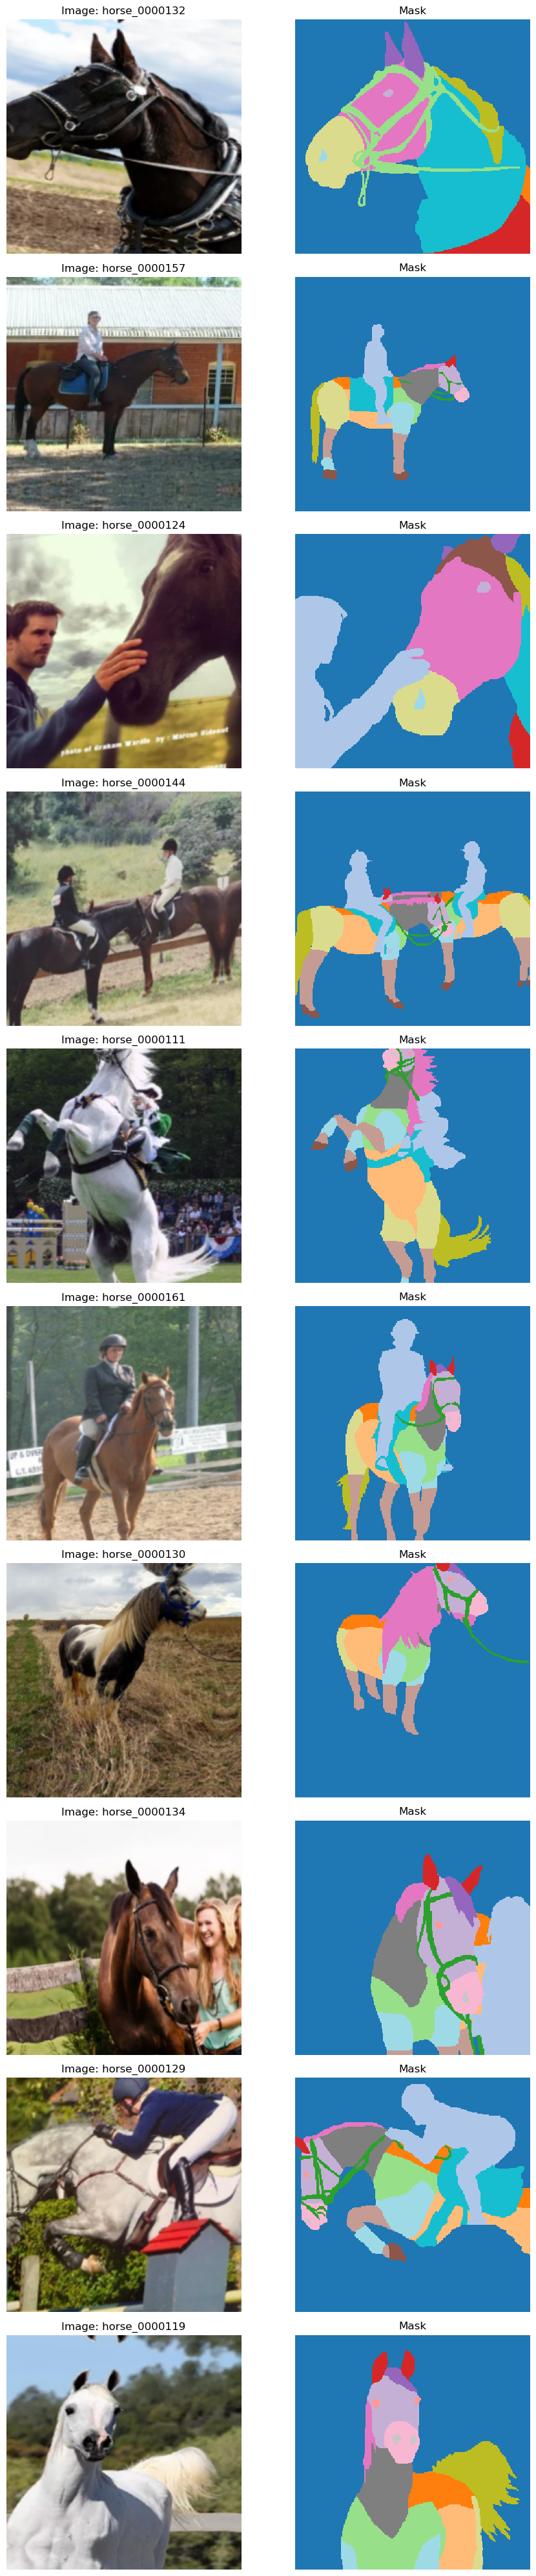

In [18]:
def show_images_and_masks(path, num_samples=5, randomize=True):

    img_paths = sorted(glob.glob(os.path.join(path, "*.png")))
    if len(img_paths) == 0:
        print(f"Ingen billeder fundet i {path}")
        return

    # Vælg subset
    if randomize:
        img_paths = np.random.choice(img_paths, size=min(num_samples, len(img_paths)), replace=False)
    else:
        img_paths = img_paths[:num_samples]

    # Lav figuren
    plt.figure(figsize=(10, 4 * len(img_paths)))

    for i, img_path in enumerate(img_paths, start=1):
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        mask_path = os.path.join(path, f"{base_name}.npy")

        # Indlæs billede
        img = np.array(PILImage.open(img_path).convert("RGB"))

        # Indlæs maske (hvis den findes)
        if os.path.exists(mask_path):
            mask = np.load(mask_path)
        else:
            mask = None

        # Vis billede
        plt.subplot(len(img_paths), 2, 2 * i - 1)
        plt.imshow(img)
        plt.title(f"Image: {base_name}")
        plt.axis("off")

        # Vis maske (hvis den findes)
        plt.subplot(len(img_paths), 2, 2 * i)
        if mask is not None:
            plt.imshow(mask, cmap="tab20", interpolation="nearest")
            plt.title("Mask")
        else:
            plt.text(0.5, 0.5, "No mask found", ha="center", va="center", fontsize=12)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


base = "ddpm-segmentation/datasets/ucloud horse_21 exp"
subpath = "elastic_transform_severity1/train"

path = os.path.join(base, subpath)

show_images_and_masks(path, num_samples=10)

